# Ejercicio 2_ Solución_Predicción de series temporales múltiples

# Parte I

In [233]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import gc
import sys
from tqdm import tqdm

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

notebookstart= time.time()

Tensorflow Version: 2.1.0
Pandas Version: 1.1.1
Numpy Version: 1.19.5
System Version: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]


In [234]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
print("DataFrame Shape: {} rows, {} columns".format(*df.shape))
display(df.head())

DataFrame Shape: 420551 rows, 15 columns


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [235]:
df.shape

(420551, 15)

In [236]:
df = df.rename(columns = {'p (mbar)': 'p', 'T (degC)': 'T',
                         'rho (g/m**3)': 'rho'}, inplace = False)


In [237]:
df['Date Time'] = pd.to_datetime(df['Date Time'])

In [238]:
df['time'] = [i.strftime("%H:%M:%S") for i in df['Date Time']]
df_selection = df.loc[df.time == '00:10:00']
df_selection

,Date Time,p,T,Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho,wv (m/s),max. wv (m/s),wd (deg),time
0,2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30,00:10:00
144,2009-02-01 00:10:00,999.55,-4.60,268.60,-5.52,93.20,4.34,4.04,0.29,2.52,4.04,1294.58,0.85,1.38,151.20,00:10:00
288,2009-03-01 00:10:00,1002.39,-4.89,268.09,-6.16,90.70,4.24,3.85,0.39,2.39,3.84,1299.75,0.80,1.38,13.01,00:10:00
432,2009-04-01 00:10:00,992.79,-1.83,271.89,-6.29,71.40,5.34,3.81,1.53,2.39,3.84,1272.79,1.44,2.63,214.10,00:10:00
576,2009-05-01 00:10:00,985.06,-1.50,272.83,-2.51,92.80,5.47,5.08,0.39,3.21,5.15,1260.74,1.59,3.50,231.00,00:10:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419831,2016-12-27 00:10:00,1003.13,3.55,276.46,-1.98,66.96,7.88,5.28,2.60,3.28,5.26,1260.36,2.30,6.49,244.20,00:10:00
419975,2016-12-28 00:10:00,1011.58,6.27,278.51,2.61,77.30,9.54,7.37,2.16,4.54,7.29,1257.64,2.80,4.81,262.40,00:10:00
420119,2016-12-29 00:10:00,1015.16,3.40,275.37,2.05,90.80,7.80,7.08,0.72,4.35,6.98,1275.34,0.74,1.44,225.80,00:10:00
420263,2016-12-30 00:10:00,1012.42,-1.82,270.39,-2.06,98.20,5.34,5.25,0.10,3.23,5.18,1297.24,1.14,1.72,213.70,00:10:00


In [239]:
features_considered = ['p', 'T', 'rho']
features = df_selection[features_considered]

In [243]:
features.index = df_selection['Date Time']
features.head()

,p,T,rho
Date Time,,,
2009-01-01 00:10:00,996.52,-8.02,1307.75
2009-02-01 00:10:00,999.55,-4.60,1294.58
2009-03-01 00:10:00,1002.39,-4.89,1299.75
2009-04-01 00:10:00,992.79,-1.83,1272.79
2009-05-01 00:10:00,985.06,-1.50,1260.74


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B7544763C8>,
      dtype=object)

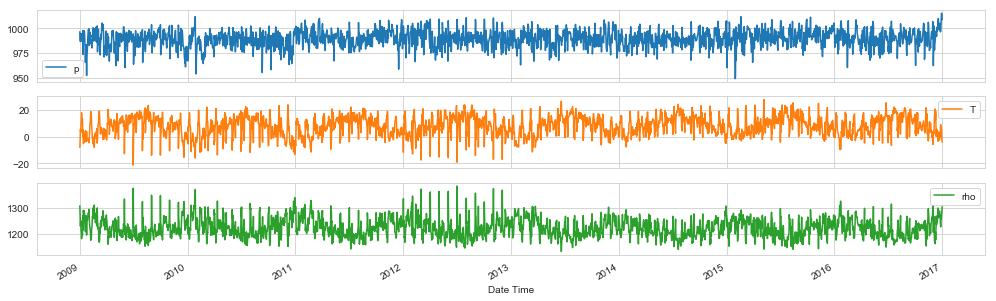

In [221]:
features.plot(subplots=True)

In [244]:
# extraer características de
features['month'] = [i.month for i in df_selection['Date Time']]
features['year'] = [i.year for i in df_selection['Date Time']]
features['day_of_week'] = [i.dayofweek for i in df_selection['Date Time']]
features['day_of_year'] = [i.dayofyear for i in df_selection['Date Time']]
features.head()

,p,T,rho,month,year,day_of_week,day_of_year
Date Time,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,1307.75,1,2009,3,1
2009-02-01 00:10:00,999.55,-4.60,1294.58,2,2009,6,32
2009-03-01 00:10:00,1002.39,-4.89,1299.75,3,2009,6,60
2009-04-01 00:10:00,992.79,-1.83,1272.79,4,2009,2,91
2009-05-01 00:10:00,985.06,-1.50,1260.74,5,2009,4,121


In [223]:
features_considered_or = features_considered

# Parte II

In [225]:
from pycaret.regression import *

#all_ts = features['time_series'].unique()

all_results = []
final_model = {}


for i in tqdm(features_considered):
    
    
    #remove innecesary columns
    features_to_remove = features_considered_or.remove(i)


    # initialize setup from pycaret.regression
    s = setup(features, target = i, train_size = 0.95,
              data_split_shuffle = False, fold_strategy = 'timeseries', fold = 3,
              numeric_features = ['day_of_year', 'year'],
              categorical_features = ['month', 'day_of_week'],
              ignore_features=features_to_remove,
              silent = True, verbose = False, session_id = 123)
    
    # compare all models and select best one based on MAE
    best_model = compare_models(sort = 'MAE', verbose=False)
    
    # capture the compare result grid and store best model in list
    p = pull().iloc[0:1]
    p['time_series'] = str(i)
    all_results.append(p)
    
    # finalize model i.e. fit on entire data including test set
    f = finalize_model(best_model)
    
    # attach final model to a dictionary
    final_model[i] = f
    
    # save transformation pipeline and model as pickle file 
    save_model(f, model_name='trained_models/' + str(i), verbose=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.77s/it]


# Parte III

In [246]:
from pycaret.regression import load_model, predict_model

all_score_df = []
for i in tqdm(features_considered):
    l = load_model('trained_models/' + str(i), verbose=False)
    p = predict_model(l, data=features)
    p['time_series'] = i
    all_score_df.append(p)

concat_df = pd.concat(all_score_df, axis=0)
concat_df.head()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.08it/s]


,p,T,rho,month,year,day_of_week,day_of_year,Label,time_series
Date Time,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,1307.75,1,2009,3,1,998.217721,p
2009-02-01 00:10:00,999.55,-4.60,1294.58,2,2009,6,32,1000.378099,p
2009-03-01 00:10:00,1002.39,-4.89,1299.75,3,2009,6,60,1003.472379,p
2009-04-01 00:10:00,992.79,-1.83,1272.79,4,2009,2,91,993.307571,p
2009-05-01 00:10:00,985.06,-1.50,1260.74,5,2009,4,121,985.133727,p


In [247]:
concat_df.tail()

,p,T,rho,month,year,day_of_week,day_of_year,Label,time_series
Date Time,,,,,,,,,
2016-12-27 00:10:00,1003.13,3.55,1260.36,12,2016,1,362,1259.901292,rho
2016-12-28 00:10:00,1011.58,6.27,1257.64,12,2016,2,363,1257.958076,rho
2016-12-29 00:10:00,1015.16,3.40,1275.34,12,2016,3,364,1275.755620,rho
2016-12-30 00:10:00,1012.42,-1.82,1297.24,12,2016,4,365,1296.494939,rho
2016-12-31 00:10:00,1008.64,-4.17,1304.27,12,2016,5,366,1302.631748,rho
